# CHAT-BOT ANALYSIS

In [1]:
# import libraries here
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Leemos el csv
chatbot=pd.read_csv('chatbot_usuarios.csv', sep=';', header=0,encoding = 'unicode_escape')
chatbot.head(2)

,PREGUNTAS FRECUENTES,USUARIOS,FECHA,EDAD
0,que significa ux?,usuario 1,15/10/19,18.0
1,me gustaria saber informacion sobre el bootcam...,usuario 2,15/10/19,22.0


In [2]:
# Nos quedamos solo con los 14 usuarios (los demás se repiten)
df_usuarios = chatbot[0:14][['USUARIOS','EDAD']]
# Eliminamos la columna ['EDAD'] para rellenar las edades a continuación;
df_chatbot = chatbot.drop(['EDAD'], axis=1)
# Creamos la nueva versión ['EDAD'] completa
chatbot = pd.merge(df_chatbot, df_usuarios,  how='left', left_on=['USUARIOS'], right_on = ['USUARIOS'])

# Limpiamos tokenizando y agregando en una columna nueva los datos limpios
from nltk import sent_tokenize, word_tokenize
# Metemos cada frase en una lista tokenizada 
chatbot['PF_PALABRAS']=chatbot['PREGUNTAS FRECUENTES'].apply(word_tokenize)

In [3]:
# Mediante la construcción de una función, limpiamos la nueva columna

def clean_up(s):
    """
    Cleans up numbers, URLs, and special characters from a string.

    Args:
        s: The string to be cleaned up.

    Returns:
        A string that has been cleaned up.
    """
    import re
    s = re.sub("http://ironhack.com", ' ', s)
    s = re.sub('\d+', ' ', s)
    s = re.sub('\W+', ' ', s)
    s = s.lower().strip()
    return s

In [4]:
# Aplicamos la función 'clean_up'
chatbot['PF_PALABRAS']=chatbot['PREGUNTAS FRECUENTES'].apply(clean_up)

In [5]:
# Creamos una función para tokenizar las siguientes columnas
def tokenize(s):
    """
    Tokenize a string.

    Args:
        s: String to be tokenized.

    Returns:
        A list of words as the result of tokenization.
    """
    from nltk import word_tokenize
    s = word_tokenize(s)
    return s

In [6]:
# Aplicamos la función 'tokenize'
chatbot['PF_LISTA']=chatbot['PF_PALABRAS'].apply(tokenize)
# Contamos el número de palabras del PREGUNTAS FRECUENTES.
chatbot['word_count'] = chatbot['PF_LISTA'].apply(len)
# Sacamos el número de stops words que hay en PREGUNTAS FRECUENTES marcando el idioma español.
stop = stopwords.words('spanish')
chatbot['stopwords'] = chatbot['PF_LISTA'].apply(lambda comment: len([word for word in comment if word in stop]))

In [7]:
stop_words = ['a', 'con', 'de', 'desde', 'en', 'entre', 'hasta', 'para', 'por', 'sin', 'sobre', 'tras', 'via', 'me', 'mi', 'te', 'el', 'la','el', 'que','tipo','puedo','puede','ser']

for pregunta in chatbot['PF_LISTA']:
    for word in pregunta:
        if word in stop: pregunta.remove(word)
        elif word in stop_words: pregunta.remove(word)
            

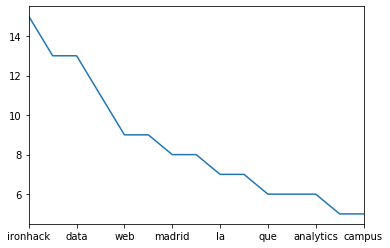

In [8]:
# Buscamos las palabras más frecuentes.
freq = pd.Series(' '.join(" ".join(comment) for comment in chatbot['PF_LISTA']).split(" ")).value_counts()[:15]
freq.plot()

In [9]:
# Buscamos las palabras menos frecuentes.
less_freq = pd.Series(' '.join(" ".join(comment) for comment in chatbot['PF_LISTA']).split(" ")).value_counts()[-10:]
# Eliminamos las palabras menos frecuentes.
less_freq_list = list(less_freq.index)
chatbot['PF_LISTA'] = chatbot['PF_LISTA'].apply(lambda comment: [word for word in comment if word not in less_freq_list])

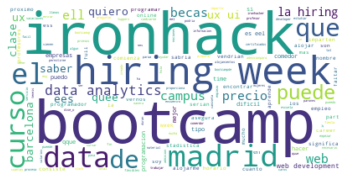

In [10]:
# Creamos y descargamos una nube de palabras para poder analizar cuáles son las palabras más utilizadas.

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

wordcloud = WordCloud(max_font_size=70, background_color="White").generate(" ".join(" ".join(comment) for comment in chatbot['PF_LISTA']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")


plt.savefig('nube.png')
plt.show()

In [11]:
# Creamos una lista con las palabras clave que queremos analizar

keywords=['data','web','ux']

def key_words(x):
    new_list=[]
    for word in x:
        if word in keywords:
            new_list.append(word)
    return new_list

In [12]:
# Aislamos en una nueva lista las palabras clave
chatbot['KEY_WORDS']=chatbot['PF_LISTA'].apply(key_words)
# Mediante una función, pasamos la columna de 'KEY_WORDS' a strings, para su posterior análisis
def key_words_string(x):
    lista = []
    for word in x:
        if word in keywords:
            return word

In [13]:
# Aplicamos la función 'key_words_string' para extraer las palabras como 'strings'
chatbot['KEY_WORDS_STR']=chatbot['PF_LISTA'].apply(key_words_string)
# Contamos la cantidad de palabras clave que cada usuario ha mencionado para analizar el interés del bootcamp 
chatbot['key_count'] = np.where(chatbot['KEY_WORDS_STR'].isin(keywords), 1,0)
# Rellenamos los campos con 'nada', donde no se ha preguntado sobre algún bootcamp en concreto
#chatbot['KEY_WORDS_STR'] = chatbot['KEY_WORDS_STR'].fillna('Nada')

In [14]:
# Resultado de qué bootcamp se pregunta más 
sum_keywords = chatbot['KEY_WORDS_STR'].value_counts()
sum_keywords

data    13
web      9
ux       8
Name: KEY_WORDS_STR, dtype: int64

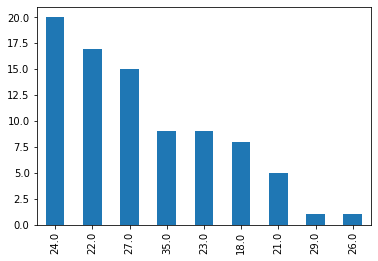

In [15]:
# Analizamos las edades
menor_edad = chatbot['EDAD'].min() # 18
mayor_edad = chatbot['EDAD'].max() # 35
mean_edad = chatbot['EDAD'].mean() # 24.5
# Sacamos el número de personas por edad
sum_edad = chatbot['EDAD'].value_counts()
# Gráfica que repesenta la cantidad de personas por edades
chatbot['EDAD'].value_counts().plot(kind='bar')

In [16]:
# Sacamos por cada usuario cuantas key words han mencionado
# usuario_total_key = chatbot.groupby('USUARIOS').agg({'key_count' : 'sum',})
# Resultado numérico sobre el bootcamp de más interés
key_count_df = chatbot.groupby('KEY_WORDS_STR').agg({'key_count' : 'sum',})
key_count_df

,key_count
KEY_WORDS_STR,
data,13
ux,8
web,9


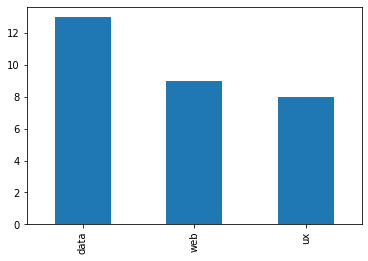

In [17]:
chatbot['KEY_WORDS_STR'].value_counts().plot(kind='bar')

In [18]:
# Sacamos por cada usuario el bootcamp sobre el que se ha interesado

usuario_key_count = chatbot.pivot_table(chatbot,index=['USUARIOS','KEY_WORDS_STR'], aggfunc='count')
usuario_key_count['KEY_WORDS']

USUARIOS    KEY_WORDS_STR
usuario 1   data             4
            ux               2
usuario 10  data             2
            ux               2
            web              1
usuario 11  data             1
usuario 13  data             1
usuario 14  ux               4
            web              1
usuario 2   web              1
usuario 3   data             4
            web              4
usuario 4   data             1
usuario 5   web              1
usuario 7   web              1
Name: KEY_WORDS, dtype: int64

In [19]:
usuario_key_word = usuario_key_count['KEY_WORDS'].reset_index()
usuario_bootcamp = pd.DataFrame(usuario_key_word)
usuario_bootcamp

,USUARIOS,KEY_WORDS_STR,KEY_WORDS
0,usuario 1,data,4
1,usuario 1,ux,2
2,usuario 10,data,2
3,usuario 10,ux,2
4,usuario 10,web,1
5,usuario 11,data,1
6,usuario 13,data,1
7,usuario 14,ux,4
8,usuario 14,web,1
9,usuario 2,web,1


In [20]:
# by_country = data[(data["Country"]!='United Kingdom')&(data["InvoiceDate"].dt.month==4)&(data["InvoiceDate"].dt.year==2011)].pivot_table(index=["Country"], values=["Quantity", "Revenue"], aggfunc={"Quantity":np.sum, "Revenue":np.sum})

import plotly.plotly as py
import cufflinks as cf
from ipywidgets import interact

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



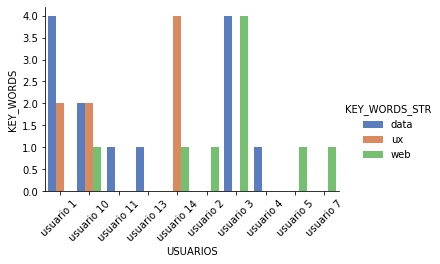

In [21]:
#sns.set(style="whitegrid") 
grafica = sns.factorplot('USUARIOS','KEY_WORDS','KEY_WORDS_STR', data=usuario_bootcamp, kind='bar',palette='muted',legend=True)
grafica.set_xticklabels(rotation=45).fig.set_figheight(3)

plt.show()